Empty DataFrame
Columns: [Bank, Pharma]
Index: []


/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/3084178698.py:12: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  bank_price = pd.read_csv("bank.csv", header=0, parse_dates=True, sep=',', index_col=0)
/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/3084178698.py:17: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  pharma_price = pd.read_csv("pharma.csv", header=0, parse_dates=True, sep=',', index_col=0)
/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/3084178698.py:30: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels([str(p.date()) for p in data[::data.shape[0]//9].index]

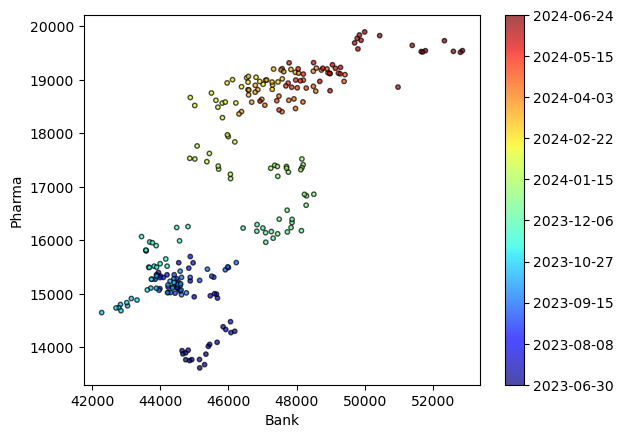

In [30]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, date
from pykalman import KalmanFilter

#################################################### Data #####################################################
sym_a = 'Bank'
bank_price = pd.read_csv("auto.csv", header=0, parse_dates=True, sep=',', index_col=0)
bank_price = bank_price["Close "]
bank_price.name = sym_a

sym_b = 'Pharma'
pharma_price = pd.read_csv("realty.csv", header=0, parse_dates=True, sep=',', index_col=0)
pharma_price = pharma_price["Close "]
pharma_price.name = sym_b

data = pd.concat([bank_price, pharma_price], axis=1)
print(data[data.isnull().any(axis=1)])
data.dropna(axis=0, how='any', inplace=True)

# colormap
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, data.shape[0])
sc = plt.scatter(data[sym_a], data[sym_b], s=10, c=colors, cmap=cm, edgecolors='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels([str(p.date()) for p in data[::data.shape[0]//9].index])
plt.xlabel('Bank')
plt.ylabel('Pharma')
plt.show()

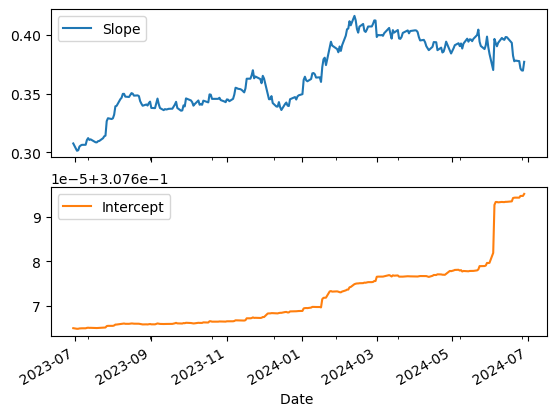

In [31]:

# ------------------------------------------- Kalman Filter --------------------------------------------------------#
state_cov_multiplier = np.power(0.01, 2)       # 0.1: spread_std=2.2, cov=16  ==> 0.01: 0.22, 0.16
observation_cov = 0.001
# observation matrix F is 2-dimensional, containing sym_a price and 1
# there are data.shape[0] observations
obs_mat_F = np.transpose(np.vstack([data[sym_a].values, np.ones(data.shape[0])])).reshape(-1, 1, 2)

kf = KalmanFilter(n_dim_obs=1,                                      # y is 1-dimensional
                  n_dim_state=2,                                    #  states (alpha, beta) is 2-dimensional
                  initial_state_mean=np.ones(2),                    #  initial value of intercept and slope theta0|0
                  initial_state_covariance=np.ones((2, 2)),         # initial cov matrix between intercept and slope P0|0
                  transition_matrices=np.eye(2),                    # G, constant
                  observation_matrices=obs_mat_F,                   # F, depends on x
                  observation_covariance=observation_cov,                   # v_t, constant
                  transition_covariance= np.eye(2)*state_cov_multiplier)           # w_t, constant

state_means, state_covs = kf.filter(data[sym_b])                 # observes sym_b price
beta_kf = pd.DataFrame({'Slope': state_means[:, 0], 'Intercept': state_means[:, 1]}, index=data.index)
beta_kf.plot(subplots=True)
plt.show()

In [32]:

# ------------------------------------This should be equivalent to above --------------------------------------------#
means_trace = []
covs_trace = []
step = 0
x = data[sym_a][step]
y = data[sym_b][step]
observation_matrix_stepwise = np.array([[x, 1]])
observation_stepwise = y
kf = KalmanFilter(n_dim_obs=1, n_dim_state=2,
                  initial_state_mean=np.ones(2),                      # initial value
                  initial_state_covariance=np.ones((2, 2)),           # initial value
                  transition_matrices=np.eye(2),                      # constant
                  observation_matrices=observation_matrix_stepwise,   # depend on x
                  observation_covariance=observation_cov,                           # constant
                  transition_covariance= np.eye(2)*state_cov_multiplier)                   # constant
# P = np.ones((2, 2)) + np.eye(2)*state_cov_multiplier
# spread = y - observation_matrix_stepwise.dot(np.ones(2))[0]
# spread_std = np.sqrt(observation_matrix_stepwise.dot(P).dot(observation_matrix_stepwise.transpose())[0][0] + observation_cov)
# print(spread, spread_std)
state_means_stepwise, state_covs_stepwise = kf.filter(observation_stepwise)             # depend on y
# print(state_means_stepwise, state_covs_stepwise)
means_trace.append(state_means_stepwise[0])
covs_trace.append(state_covs_stepwise[0])

for step in range(1, data.shape[0]):
    # print(step)
    x = data[sym_a][step]
    y = data[sym_b][step]
    observation_matrix_stepwise = np.array([[x, 1]])
    observation_stepwise = y

    state_means_stepwise, state_covs_stepwise = kf.filter_update(
        means_trace[-1], covs_trace[-1],
        observation=observation_stepwise,
        observation_matrix=observation_matrix_stepwise)

    # print(state_means_stepwise, state_covs_stepwise)
    # P = covs_trace[-1] + np.eye(2)*state_cov_multiplier                        # This has to be small enough
    # spread = y - observation_matrix_stepwise.dot(means_trace[-1])[0]
    # spread_std = np.sqrt(observation_matrix_stepwise.dot(P).dot(observation_matrix_stepwise.transpose())[0][0] + observation_cov)
    # print(spread, spread_std)
    means_trace.append(state_means_stepwise.data)
    covs_trace.append(state_covs_stepwise)

/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/3353458471.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = data[sym_a][step]
/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/3353458471.py:6: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  y = data[sym_b][step]
/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/3353458471.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  x = data[sym_

/var/folders/k6/f0fhb8d93v58fgx7968qj3gr0000gp/T/ipykernel_555/855676161.py:7: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  cb.ax.set_yticklabels(str(p.date()) for p in data[::data.shape[0]//9].index)


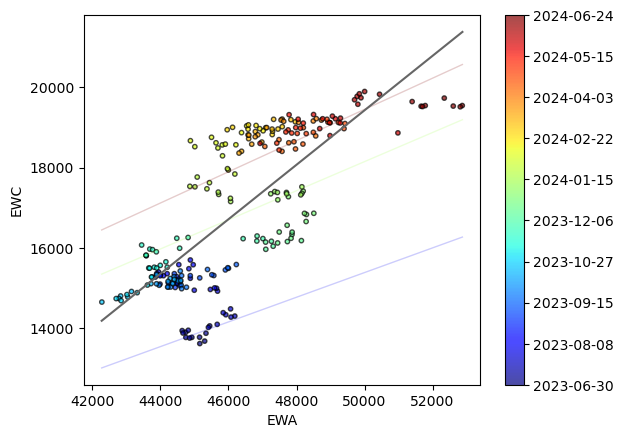

In [33]:
# ------------------------------------ line evolvement --------------------------------------------#
# colormap
cm = plt.get_cmap('jet')
colors = np.linspace(0.1, 1, data.shape[0])
sc = plt.scatter(data[sym_a], data[sym_b], s=10, c=colors, cmap=cm, edgecolors='k', alpha=0.7)
cb = plt.colorbar(sc)
cb.ax.set_yticklabels(str(p.date()) for p in data[::data.shape[0]//9].index)
plt.xlabel('EWA')
plt.ylabel('EWC')

step = 100
xi = np.linspace(data[sym_a].min()-5, data[sym_a].max()+5, 5)
colors_1 = np.linspace(0.1, 1, len(state_means[::step]))
for i, beta in enumerate(state_means[::step]):
    plt.plot(xi, beta[0] * xi + beta[1], alpha=0.2, lw=1, c=cm(colors_1[i]))

# plot the OLS regression for all data
plt.plot(xi, np.poly1d(np.polyfit(data[sym_a], data[sym_b], 1))(xi), '0.4')

plt.show()